## Part 0 - README

Would need a GPU to run this notebook within reasonable amount of time.

In [1]:
import copy
import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import os.path
import urllib3
import torch.nn as nn
import torch
from torch.utils.data import DataLoader, TensorDataset
import pickle

%load_ext autoreload
%autoreload 2

# Define color palette for the graphs later on
color_palette = [
    'royalblue',
    'orange',
    'mediumseagreen',
    'mediumorchid',
    'orangered',
    "slategray",
    "lightpink",
    "lightsalmon",
    "olive",
    "aqua"
]

# Set to CUDA
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

## Part 1 - Helper Functions

Please execute the following code block to load a few functions necessary for the simulator to run.

Note that all the imported helper functions are written for this project. They do contain mission critical code but would make this main notebook too clumsy if we include them all here. I will introduce their functions, and feel free to take a look if you are curious.

#### Util
Contains most of the functions related to processing raw HAR(Http Archive Format) that we got from browsermob-proxy.
- `is_json`: check whether a string is a valid json structure
- `parse_har`: har is collected as a dictionary. This function converts it into a Pandas DataFrame. It selectively includes a few features from HAR that I think is useful for the project. If you want the PDF to include more feature you should modify this function.
- `postprocess_har`: calculate discretized timestamp and relative time window for the har

#### trace_gen
Contains most of the code that generates website asset load traces. This file also has dependency in `gen_types.py` which defines a few classes that it use.
- `gen_trace`: a big wrapper around the whole trace generator. Given the number of concurrent workers and other parameters, return a dictionary of HAR

#### plotter
Contains a few functions related to plotting graphs used in this notebook. Also responsible for calculating rolling average on the access frequency (since that is used during plotting, might as well)
- `plot_frequency`: given the whole post-processed HAR and a single URL of interest, return their **smoothed** access frequency that is used in plotting and LSTM training/inferencing
- `plot_frquencies`: a simple wrapper around `plot_frequency` to allow multiple urls being used at the same time

In [3]:
from util import is_json, postprocess_har, parse_har, download
from trace_gen import gen_trace
from plotter import plot_frequencies, plot_frequency

## Part 2 - Trace Generator

In this part we do the trace generation. **NOTE:** the first boolean variable in the next cell, `gen_trace` decides whether we do the trace generation. If set false, we will attempt to download the file from my personal S3 so that this script can run end to end.

In [4]:
gen_trace = False
base_path = "cs.uchicago.edu"

# ---------------------
num_worker = 24
num_user = 600
mission_hour = 6
# ---------------------

mission_minutes = mission_hour*60
mission_seconds = mission_hour*60*60

# ---------------------


file_suffixes = ['.har', '.pandas']
file_name = "user_{}_hour_{}_{}".format(num_user, mission_hour, base_path)

if gen_trace:
    aggregate_har, sys = gen_trace(base_path, num_user, mission_minutes, num_worker)
else:
    # Check whether the file we want exist
    for suffix in file_suffixes:
        file_fullname = file_name + suffix
        if not os.path.isfile(file_fullname):
            # This means we would need to download this file from S3
            url = 'https://minio.naturecraft.world/jiajunm-misc/{}'.format(file_fullname)
            download(url, file_fullname)

In [6]:
# Load the HAR dict pickle file
har = pickle.load(open(file_name+".har", "rb"))
processed = postprocess_har(har, base_path)

url_pdf = processed.groupby('url').size().sort_values(ascending=False)
urls = url_pdf.reset_index()['url'].tolist()

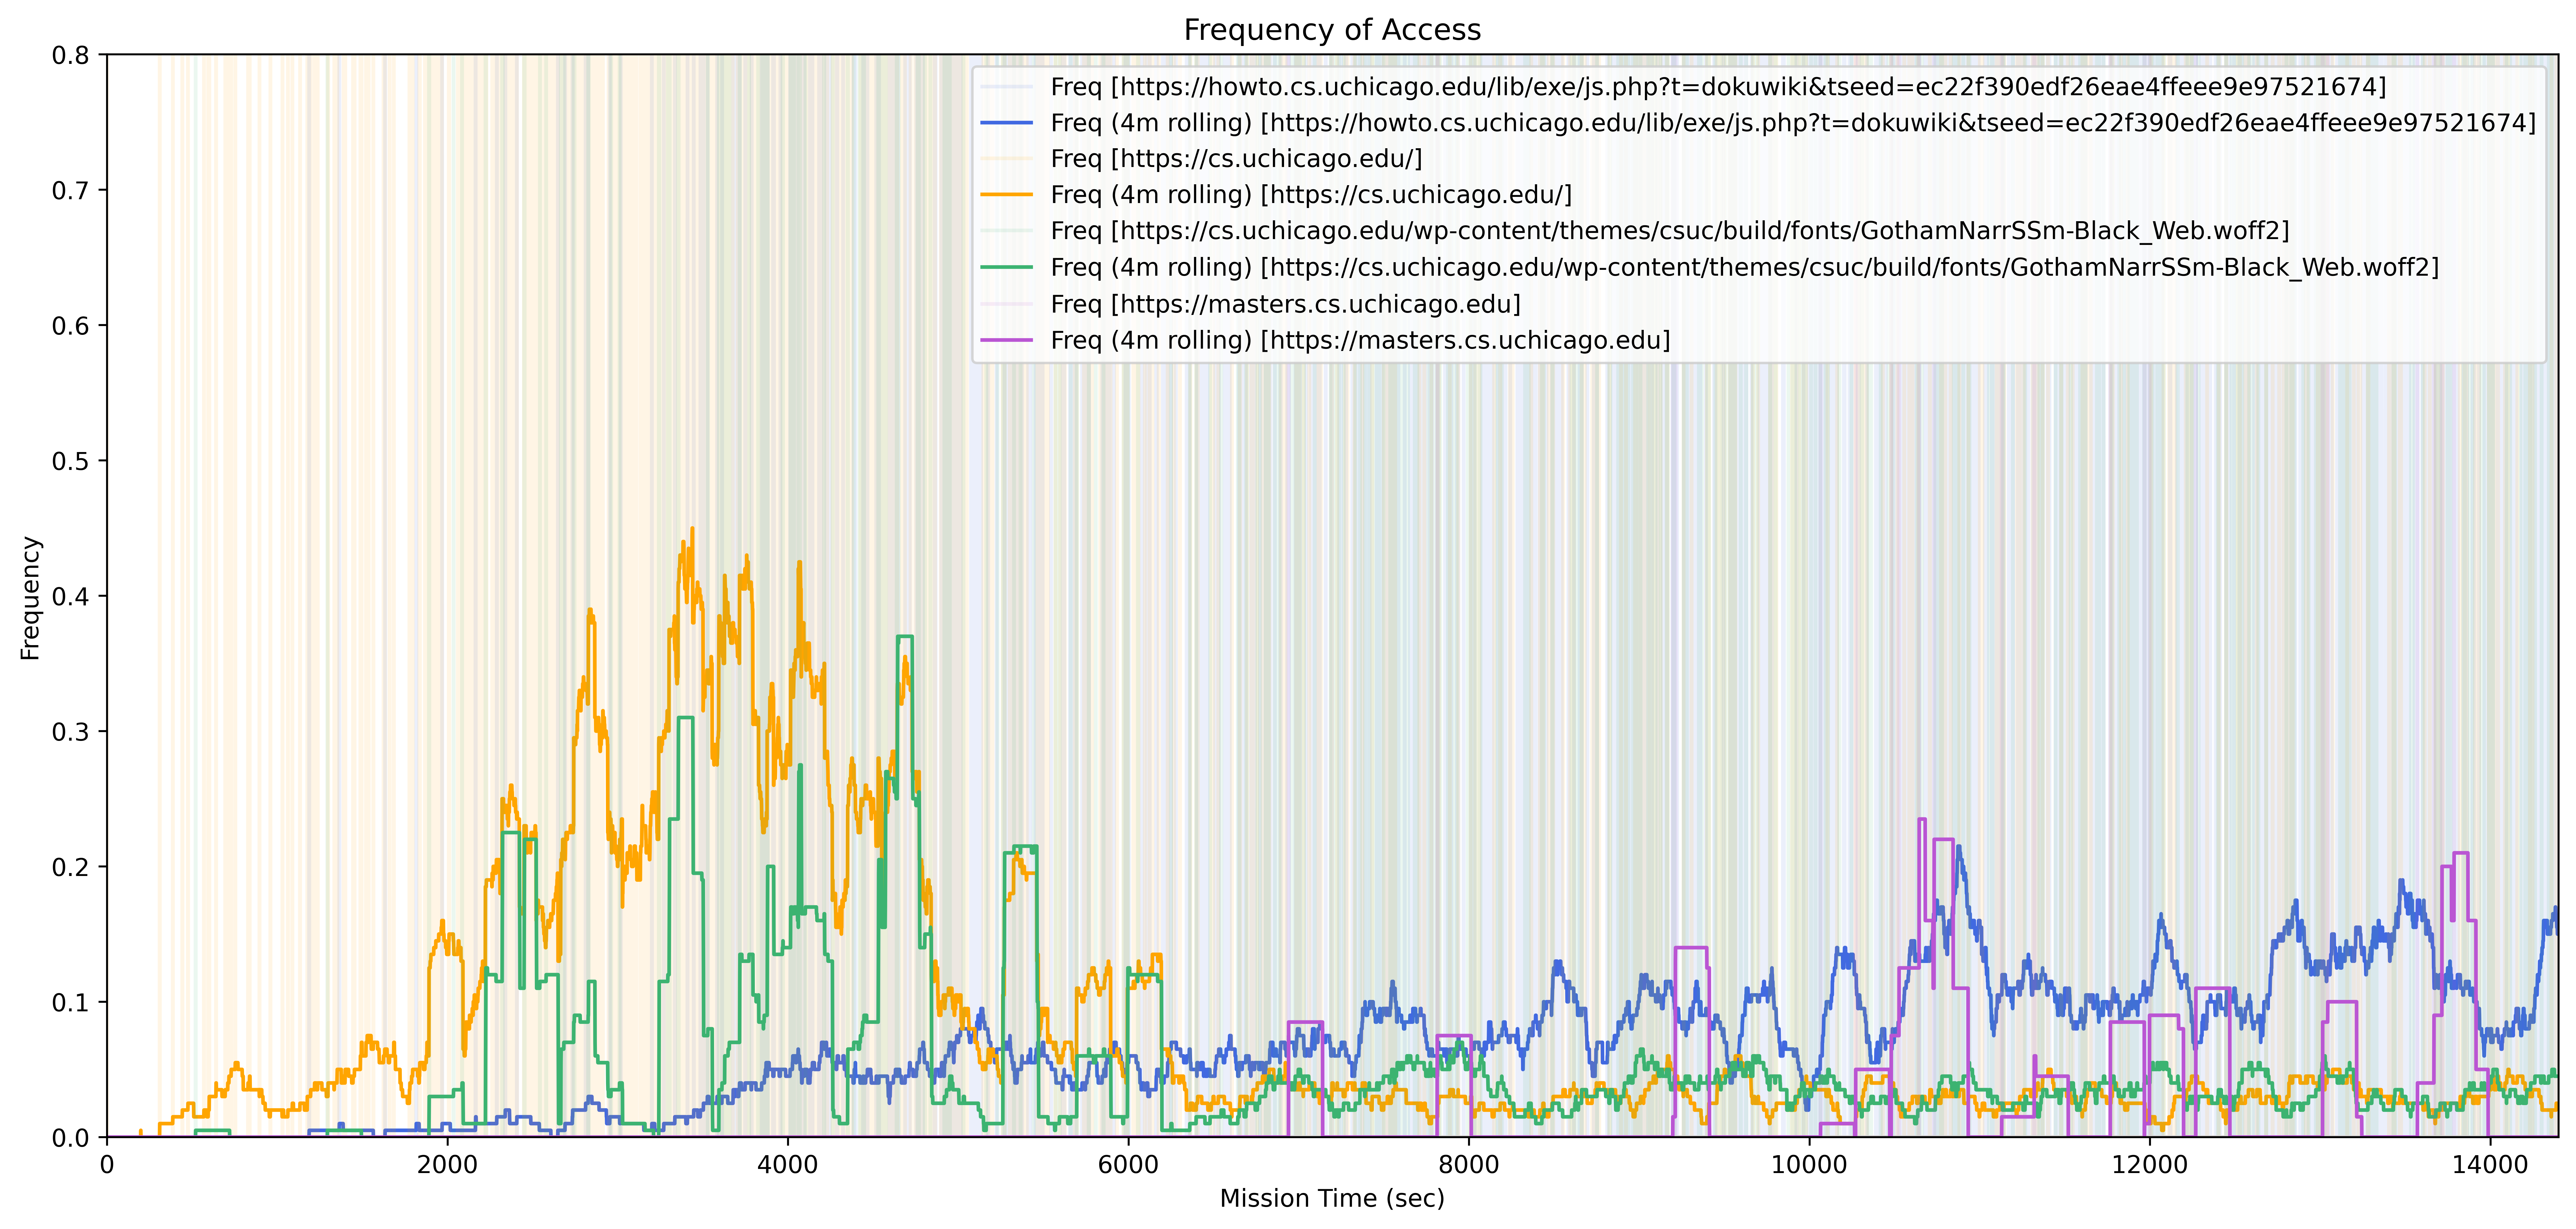

In [11]:
plot_urls = urls[1:8:2]
xclip=(0,4*3600)

frequency_pdfs = plot_frequencies(
    processed,
    plot_urls,
    4*60*60,
    200,
    (0,4*3600),
    (0,0.80)
)

## Part 3 - Define and Train the Model

In this part we define and train the model.

In [16]:
def gen_train(freq_pdf, seq_length, output_size):
    series = freq_pdf['count_rolling'].to_numpy()
    xs, ys = [], []
    for i in range(len(series) - seq_length - output_size - 1):
        xs.append(series[i:(i+seq_length)])
        ys.append(series[i+seq_length:i+seq_length+output_size])
        
    return torch.from_numpy(np.array(xs)).float().unsqueeze(-1), torch.from_numpy(np.array(ys)).float()

class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size):
        super(LSTM, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        
        self.lstm = nn.LSTM(
            input_size=input_size, 
            hidden_size=hidden_size, 
            num_layers=num_layers, 
            batch_first=True, 
            bidirectional=False,
            dropout=0.4)
        
        self.fc = nn.Sequential(
            nn.Linear(hidden_size, output_size),
            nn.BatchNorm1d(output_size),
            nn.ReLU()
        )
        
        for name, param in self.lstm.named_parameters():
            if 'bias' in name:
                nn.init.constant_(param, 0.0)
            elif 'weight' in name:
                nn.init.xavier_normal_(param)
                
    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])
        return out

input_size = 1
hidden_size = 50
num_layers = 2
# output_size is how many data points we predict into the future
output_size = 150
model = LSTM(input_size, hidden_size, num_layers, output_size).to(device)

learning_rate = 1e-4

criteria = nn.HuberLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
lr_scheduler = torch.optim.lr_scheduler.StepLR(verbose=False, optimizer=optimizer, gamma=0.1, step_size=40)

# Window size is how many data points we use to predict the future
window_size=300

# Select a few from the frequency_pdf as the training data
X, Y = gen_train(frequency_pdfs[0], window_size, output_size)
Y = Y.reshape(-1,output_size)
stack_num = 3
for i in range(1,(stack_num+1)*2,2):
    X1, Y1 = gen_train(frequency_pdfs[i], window_size, output_size)
    Y1 = Y1.reshape(-1,output_size)
    X = torch.vstack((X,X1))
    Y = torch.vstack((Y,Y1))

Y = Y.reshape(-1,output_size)

print(X.shape)
print(Y.shape)

torch.Size([69745, 300, 1])
torch.Size([69745, 150])


### Part 3.1 - To Train or Not to Train

Set `train=True` to actually train the model. If `train=False`, we will again download the trained model from S3 bucket.

In [ ]:
# -----
train=False
# -----

if train:
    num_epochs = 100
    losses = []

    dataset_train = TensorDataset(X, Y)
    dataloader = DataLoader(dataset_train, batch_size=256, shuffle=True, num_workers=24, pin_memory=True)

    for epoch in range(num_epochs):
        for id_batch, (x_batch, y_batch) in enumerate(dataloader):
            x_batch = x_batch.to(device)
            y_batch = y_batch.to(device)
            # print(y_batch)
            outputs = model(x_batch)
            # print(outputs)
            y_batch = y_batch.reshape(outputs.shape)
            
            optimizer.zero_grad()
            # Attempt to penalize hard for negative value outputs
            loss = criteria(outputs, y_batch) + torch.any(outputs < 0).long().cpu()
            loss.backward()
            optimizer.step()
            
        lr_scheduler.step()
            
        print("Epoch: {}/{}, Loss: {:.8f}".format(epoch+1, num_epochs, loss.item()))
        losses.append(loss.item())

    plt.plot(range(0, num_epochs), losses)

In [19]:
if not train:
    download("https://minio.naturecraft.world/jiajunm-misc/model.pt", "model.pt")
    model.load_state_dict(torch.load('model.pt', map_location=device))
    model.eval()

LSTM(
  (lstm): LSTM(1, 50, num_layers=2, batch_first=True, dropout=0.4)
  (fc): Sequential(
    (0): Linear(in_features=50, out_features=150, bias=True)
    (1): BatchNorm1d(150, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
  )
)

## Part 4 - Run Some Inference

This will run the trained model on a few assets to show that the model generalize quite well to assets that it had never seen before.

In [20]:
def infer_plot_pred(test_pdf, url):
    test_X, _ = gen_train(test_pdf, window_size, output_size)

    dataset_test = TensorDataset(test_X)
    dataloader_test = DataLoader(dataset_test, batch_size=64)

    model.eval()
    y_test_preds = []
    for id_batch, (x_batch) in enumerate(dataloader_test):
        x_batch = x_batch[0].to(device)
        y_pred = model(x_batch)
        y_pred = y_pred.cpu().detach().numpy()
        
        for batch_pred in y_pred:
            # print(batch_pred.shape)
            y_test_preds.append(batch_pred[-1])
    
    model.train()
    plt.figure(figsize=(30, 4), dpi=200)
    plt.plot(test_pdf['count_rolling'], label="True Freq")
    plt.plot([0]*window_size + [0]*xclip[0] + y_test_preds, label="Prediction")
    plt.xlim(xclip)
    # plt.ylim((0, 0.25))
    plt.title("URL: {}".format(url))
    plt.legend(loc='upper right')

for i in range(len(frequency_pdfs)):
    infer_plot_pred(frequency_pdfs[i], plot_urls[i])

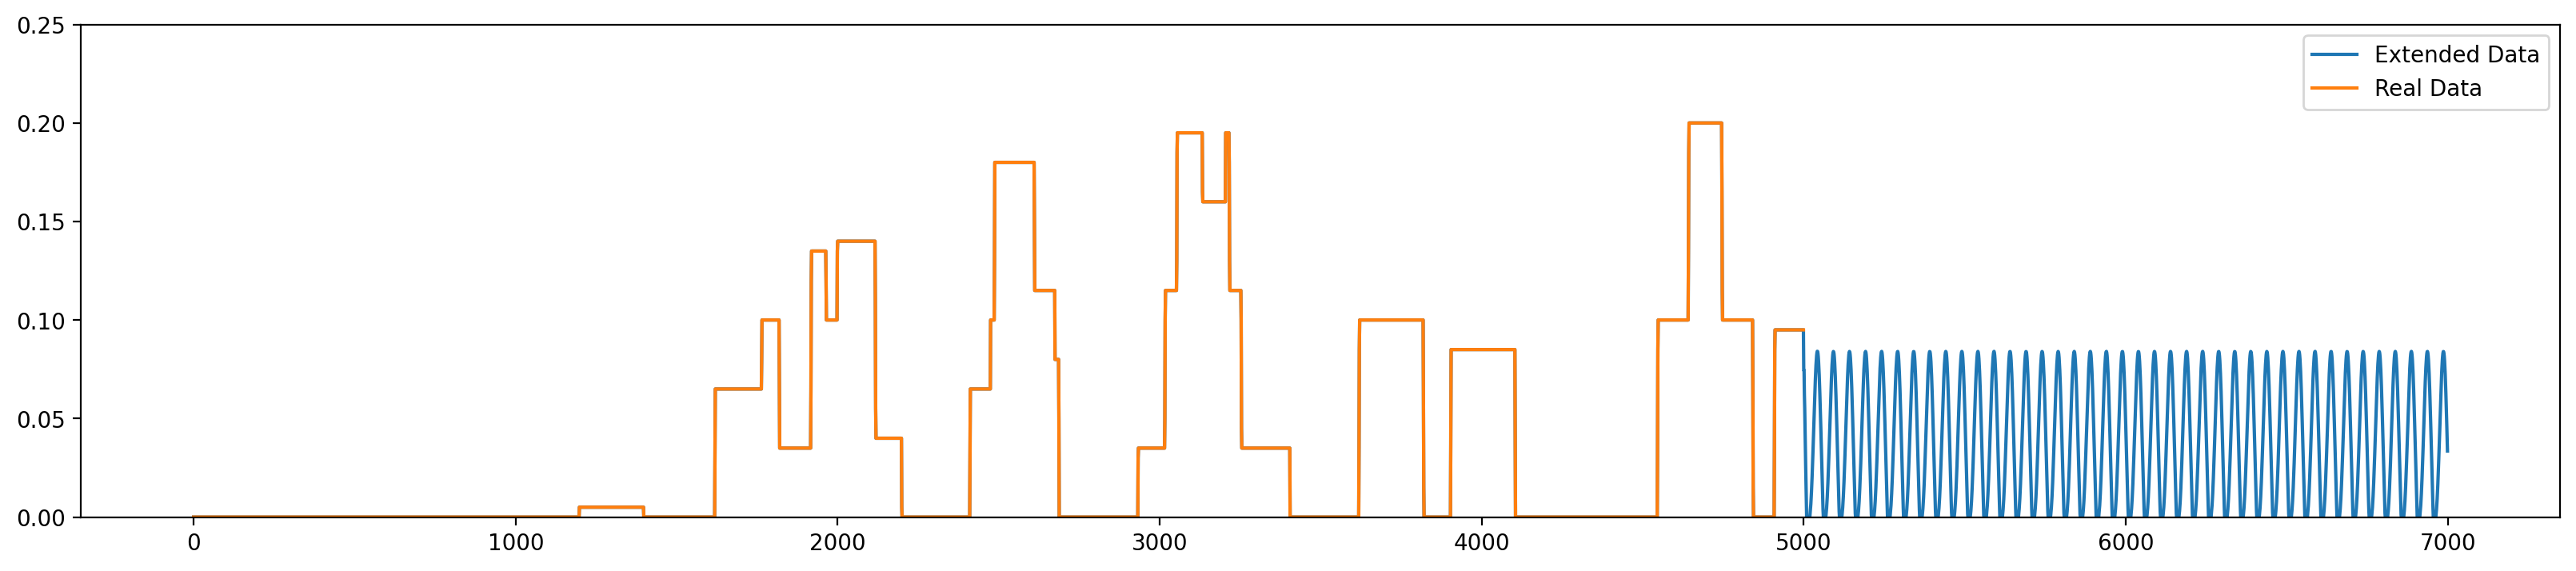

In [21]:

real_data = frequency_pdfs[2]['count_rolling'].to_numpy()[xclip[0]:5000]

extend_count = 2000  
extended_data = list(copy.deepcopy(real_data))

model.eval()

for i in range(extend_count):
    x_input = extended_data[-1-window_size:-1]
    x_input = torch.Tensor(x_input).to(device).reshape((1, window_size, 1))
    
    y_pred = model(x_input)
    y_pred = y_pred.cpu().detach().numpy()
    
            
    extended_data.append(y_pred.flatten().tolist()[-1])

model.train()    
plt.figure(figsize=(20, 4), dpi=200)

plt.plot(extended_data, label='Extended Data')
plt.plot(real_data, label="Real Data")
plt.ylim(0, 0.25)
plt.legend(loc='upper right')

## Part 5 - CDN Simulation

The CDN comes with three functions
- `fetch()`: simulate a CDN access. Will put unseen asset into the hashmap, and move existing cached asset to the tail, such at the head of the hashmap is the least recently accessed. This is doable because Python's hashmap maintains insertion order.
- `evict()`: implements a simple LRU algorithm that starts evicting from the head of the hashmap until we have enough space
- `evict_with_prediction()`: implements the proposed LLU algorithm that evicts the first resource that has use likelihood below certain value.

In [24]:
# Load the HAR dict pickle file
uchicago_har = pickle.load(open("user_600_hour_6_cs.uchicago.edu.har", "rb"))
uchicago_har = parse_har(uchicago_har)
uchicago_har = uchicago_har.sort_values('start_time', ascending = True)
uchicago_har = uchicago_har[uchicago_har['start_time'] < '2023-11-27 23:27:41']

### Part 5.1 - Define the CDN

In [26]:
class CDN:
    
    # The CDN implements a clock-handle 
    def __init__(self, size_mb: int) -> None:
        self.size = size_mb * 1024 * 1024
        self.hashmap = {}
        self.current_size = 0
    
        # Counters
        self.total_requests = 0
        self.hit = 0
        
        self.prediction = False
        self.time_window_start = 0
        
        # Related to LSTM time quanta
    
    def fetch(self, path: str, size: int):
        # print("Accessing {}".format(path))
        self.total_requests += 1
        # Has it cached, return, do nothing
        # NOTE: we ignore CDN's fetching update, not important
        if path in self.hashmap:
            self.hit += 1
            # Pop and Push, Python Dict maintains insertion order
            value = self.hashmap.pop(path)
            self.hashmap[path] = value
            
            return value
        
        # Not cached, we need to grab
        if self.current_size + size > self.size:
            if self.prediction == False:
                self.evict(size)
            else: 
                self.evict_with_prediction(size)
                
            
        # After evict, we insert
        self.hashmap[path] = (path, size)
        self.current_size += size
        # print("Newly cached. Size now is {}/{} bytes, {:.2f}% full".format(self.current_size, self.size, self.current_size/self.size*100))
        
    def evict(self, incoming_size):
        # Remove the head of the dict, until size+self.current_size < self.size_mb
        while self.current_size + incoming_size > self.size:
            # Pop the head
            key = next(iter(self.hashmap))
            value = self.hashmap.pop(key)
            
            self.current_size -= value[1]
            # print("Evicting {}".format(key))
            
    def evict_with_prediction(self, incoming_size):
        # Remove the head of the dict, until size+self.current_size < self.size_mb
        print('self.time_window_start')
        while self.current_size + incoming_size > self.size:
            # Pop the head
            print(self.time_window_start)
            if self.time_window_start > 500:
                list_key = list(self.hashmap.keys()).copy()
                for urls_ in list_key:
                    # print(urls_)
                    frequency_pdfs = frequency(
                        gatech_processed,
                        urls_,
                        4*60*60,
                        200,
                        (0,4*3600),
                    )
                    frequency_pdfs
                    extended_data = list(frequency_pdfs['count_rolling'].to_numpy()[self.time_window_start - 150:self.time_window_start])
                    x_input = extended_data
                    x_input = torch.Tensor(x_input).to(device).reshape((1, 150, 1))
                    model.eval()
                    y_pred = model(x_input)
                    y_pred = y_pred.cpu().detach().numpy()
                    if np.sum(y_pred) < 1:
                        key = urls_
                        value = self.hashmap.pop(key)
                        self.current_size -= value[1]
                        return
            key = next(iter(self.hashmap))
            value = self.hashmap.pop(key)
            self.current_size -= value[1]
            # print("Evicting {}".format(key))

### Part 5.2 - CDN with LRU

In [28]:
cdn = CDN(100)

for row in uchicago_har.iloc():
    path = row['url']
    size_mb = row['body_size']
    
    cdn.fetch(path, size_mb)

print("Hit Ratio With LRU: {:.2f}%".format(cdn.hit/cdn.total_requests*100))

### Part 5.3 - CDN with LLU

In [33]:
cdn = CDN(100)
cdn.prediction = True
count = 0
# print(len(uchicago_har))
for row in uchicago_har.iloc():
    count += 1 
    path = row['url']
    size_mb = row['body_size']
    cdn.time_window_start = round((row.start_time - uchicago_har.start_time.min()).total_seconds() )
    cdn.fetch(path, size_mb)
    
print("Hit Ratio With Prediction: {:.2f}%".format(cdn.hit/cdn.total_requests*100))

self.time_window_start
2882
self.time_window_start
2882
self.time_window_start
2882
self.time_window_start
2882
self.time_window_start
2882
self.time_window_start
2882
self.time_window_start
2882
self.time_window_start
2882
self.time_window_start
2882
self.time_window_start
2882
self.time_window_start
2882
self.time_window_start
2882
self.time_window_start
2882
self.time_window_start
2882
self.time_window_start
2883
self.time_window_start
2883
self.time_window_start
2883
self.time_window_start
2884
self.time_window_start
2890
self.time_window_start
2891
self.time_window_start
2894
self.time_window_start
2895
self.time_window_start
2895
self.time_window_start
2898
self.time_window_start
2898
self.time_window_start
2898
self.time_window_start
2899
self.time_window_start
2899
self.time_window_start
2899
self.time_window_start
2904
self.time_window_start
2904
self.time_window_start
2904
self.time_window_start
2910
self.time_window_start
2912
self.time_window_start
2912
self.time_window_sta